In [1]:
# Installing packages needed for the project
import subprocess
import sys

def install_package(package):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--break-system-packages"])
    except subprocess.CalledProcessError as e:
        print(f"Failed to install {package}: {e}")

# packages I need for this project
packages = [
    "numpy",
    "pandas", 
    "matplotlib",
    "seaborn",
    "tensorflow",
    "scikit-learn",
    "Pillow"
]

print("Installing packages...")
for package in packages:
    print(f"Installing {package}...")
    install_package(package)

print("Done installing packages!")

Installing packages...
Installing numpy...
Installing pandas...
Installing pandas...



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python3.12 -m pip install --upgrade pip


Installing matplotlib...



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python3.12 -m pip install --upgrade pip


Installing seaborn...



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python3.12 -m pip install --upgrade pip


Installing tensorflow...



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python3.12 -m pip install --upgrade pip


Installing scikit-learn...



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python3.12 -m pip install --upgrade pip


Installing Pillow...



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python3.12 -m pip install --upgrade pip


Done installing packages!



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python3.12 -m pip install --upgrade pip


## Step 1: Importing Libraries

In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# tensorflow and keras stuff
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2  # using MobileNetV2 model

# for checking accuracy and stuff
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score

import warnings
warnings.filterwarnings('ignore')


## Step 2: Setting up the data

In [3]:
# Set parameters for MobileNetV2
IMG_SIZE = 224  # MobileNetV2 standard input size
BATCH_SIZE = 16  # Reasonable batch size for MobileNetV2
EPOCHS = 20

# where my data is stored
data_path = 'depression_data'  # folder with depression/not depression images

# making more training images by rotating, flipping etc
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    zoom_range=0.3,
    brightness_range=[0.6, 1.4],
    shear_range=0.2,
    fill_mode='nearest'
 )

# for validation and test data, less changes
val_test_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=10
 )

# loading training images
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_path, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',  # need color images
    shuffle=True
 )

# loading validation images
val_generator = val_test_datagen.flow_from_directory(
    os.path.join(data_path, 'val'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
 )

# loading test images
test_generator = val_test_datagen.flow_from_directory(
    os.path.join(data_path, 'test'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
 )


Found 3716 images belonging to 2 classes.
Found 388 images belonging to 2 classes.
Found 388 images belonging to 2 classes.
Found 388 images belonging to 2 classes.
Found 388 images belonging to 2 classes.


## Step 3: Creating the model

In [4]:
def create_mobilenetv2_model():
    """
    making the neural network model
    """
    # Load MobileNetV2 with ImageNet weights
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # freeze some layers, unfreeze others for training
    for layer in base_model.layers[:-30]:  # keep bottom layers frozen
        layer.trainable = False
    for layer in base_model.layers[-30:]:  # train top 30 layers
        layer.trainable = True
    
    # building my model layers
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        
        # adding layers to prevent overfitting
        Dropout(0.5),  # randomly turn off 50% neurons
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    return model

# Create MobileNetV2 model
model = create_mobilenetv2_model()

# set up how model will learn
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # slow learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# callbacks to help with training
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_mobilenet_depression_model.h5', monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=4, min_lr=1e-8, verbose=1)
]

trainable_layers = sum(1 for layer in model.layers[0].layers if layer.trainable)
total_params = model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])


## Step 4: Training setup

In [5]:
# setting up training weights
from sklearn.utils.class_weight import compute_class_weight

# balance the classes since data might be uneven
class_labels = np.unique(train_generator.classes)
class_weights = compute_class_weight('balanced', classes=class_labels, y=train_generator.classes)
class_weight = dict(zip(class_labels, class_weights))

# adjust weights to focus more on depression detection
improved_weights = {
    0: class_weight[0] * 1.2,  # give more importance to depressed class
    1: class_weight[1] * 0.8   # less weight to not depressed class
}


## Step 5: Training the model

In [6]:
# MobileNetV2 Training for Enhanced Depression Detection

# start training with all the settings
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    class_weight=improved_weights,  # using the balanced weights
    callbacks=callbacks,
    verbose=1
)

# Quick results analysis
best_acc = max(history.history['val_accuracy'])
final_acc = history.history['val_accuracy'][-1]


Epoch 1/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.5231 - loss: 0.9205

233/233 ━━━━━━━━━━━━━━━━━━━━ 44s 164ms/step - accuracy: 0.5468 - loss: 0.8885 - val_accuracy: 0.5876 - val_loss: 0.7033 - learning_rate: 1.0000e-04
Epoch 2/20
Epoch 2/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 38s 164ms/step - accuracy: 0.5764 - loss: 0.8063 - val_accuracy: 0.3969 - val_loss: 0.9291 - learning_rate: 1.0000e-04
Epoch 3/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 38s 164ms/step - accuracy: 0.5764 - loss: 0.8063 - val_accuracy: 0.3969 - val_loss: 0.9291 - learning_rate: 1.0000e-04
Epoch 3/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 39s 168ms/step - accuracy: 0.6036 - loss: 0.7650 - val_accuracy: 0.4046 - val_loss: 1.0800 - learning_rate: 1.0000e-04
Epoch 4/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 39s 168ms/step - accuracy: 0.6036 - loss: 0.7650 - val_accuracy: 0.4046 - val_loss: 1.0800 - learning_rate: 1.0000e-04
Epoch 4/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 39s 168ms/step - accuracy: 0.6093 - loss: 0.7491 - val_accuracy: 0.4175 - val_loss: 1.0684 - learning_rate: 1.0000e-04
Epoch 5/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 39s 16

233/233 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.6712 - loss: 0.6638 - val_accuracy: 0.6314 - val_loss: 0.7117 - learning_rate: 3.0000e-05
Epoch 8/20
Epoch 8/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.6657 - loss: 0.6733

233/233 ━━━━━━━━━━━━━━━━━━━━ 44s 190ms/step - accuracy: 0.6682 - loss: 0.6652 - val_accuracy: 0.6701 - val_loss: 0.6393 - learning_rate: 3.0000e-05
Epoch 9/20
Epoch 9/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 46s 196ms/step - accuracy: 0.6647 - loss: 0.6729 - val_accuracy: 0.6675 - val_loss: 0.6489 - learning_rate: 3.0000e-05
Epoch 10/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 46s 196ms/step - accuracy: 0.6647 - loss: 0.6729 - val_accuracy: 0.6675 - val_loss: 0.6489 - learning_rate: 3.0000e-05
Epoch 10/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.7008 - loss: 0.6224

233/233 ━━━━━━━━━━━━━━━━━━━━ 43s 183ms/step - accuracy: 0.6989 - loss: 0.6292 - val_accuracy: 0.7139 - val_loss: 0.5899 - learning_rate: 3.0000e-05
Epoch 11/20
Epoch 11/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.6782 - loss: 0.6544

233/233 ━━━━━━━━━━━━━━━━━━━━ 40s 171ms/step - accuracy: 0.6792 - loss: 0.6557 - val_accuracy: 0.7242 - val_loss: 0.6056 - learning_rate: 3.0000e-05
Epoch 12/20
Epoch 12/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 39s 168ms/step - accuracy: 0.6849 - loss: 0.6493 - val_accuracy: 0.6907 - val_loss: 0.6317 - learning_rate: 3.0000e-05
Epoch 13/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 39s 168ms/step - accuracy: 0.6849 - loss: 0.6493 - val_accuracy: 0.6907 - val_loss: 0.6317 - learning_rate: 3.0000e-05
Epoch 13/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 39s 168ms/step - accuracy: 0.6951 - loss: 0.6343 - val_accuracy: 0.7036 - val_loss: 0.6041 - learning_rate: 3.0000e-05
Epoch 14/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 39s 168ms/step - accuracy: 0.6951 - loss: 0.6343 - val_accuracy: 0.7036 - val_loss: 0.6041 - learning_rate: 3.0000e-05
Epoch 14/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.6969 - loss: 0.6369

233/233 ━━━━━━━━━━━━━━━━━━━━ 40s 170ms/step - accuracy: 0.6986 - loss: 0.6283 - val_accuracy: 0.7706 - val_loss: 0.4790 - learning_rate: 3.0000e-05
Epoch 15/20
Epoch 15/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 40s 171ms/step - accuracy: 0.6989 - loss: 0.6194 - val_accuracy: 0.7577 - val_loss: 0.5289 - learning_rate: 3.0000e-05
Epoch 16/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 40s 171ms/step - accuracy: 0.6989 - loss: 0.6194 - val_accuracy: 0.7577 - val_loss: 0.5289 - learning_rate: 3.0000e-05
Epoch 16/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 40s 170ms/step - accuracy: 0.6903 - loss: 0.6324 - val_accuracy: 0.7088 - val_loss: 0.5813 - learning_rate: 3.0000e-05
Epoch 17/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 40s 170ms/step - accuracy: 0.6903 - loss: 0.6324 - val_accuracy: 0.7088 - val_loss: 0.5813 - learning_rate: 3.0000e-05
Epoch 17/20
233/233 ━━━━━━━━━━━━━━━━━━━━ 39s 169ms/step - accuracy: 0.7099 - loss: 0.6074 - val_accuracy: 0.7448 - val_loss: 0.5693 - learning_rate: 3.0000e-05
Epoch 18/20
233/233 ━━━━━━━━━━━━━━━━━━━━

233/233 ━━━━━━━━━━━━━━━━━━━━ 41s 176ms/step - accuracy: 0.7121 - loss: 0.6013 - val_accuracy: 0.7835 - val_loss: 0.4537 - learning_rate: 9.0000e-06
Restoring model weights from the end of the best epoch: 20.
Restoring model weights from the end of the best epoch: 20.


## Step 6: Plotting training results

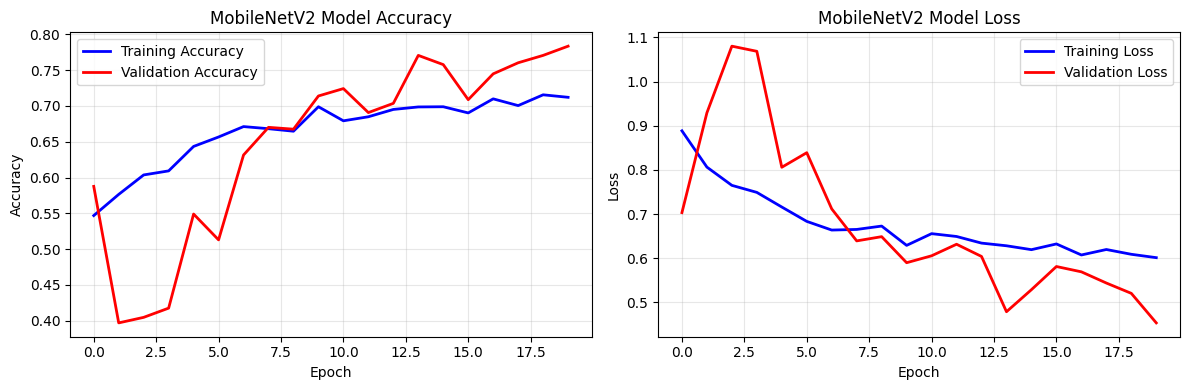

In [7]:
def analyze_overfitting_and_plot(history):
    """
    show graphs of how training went
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # accuracy graph
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linewidth=2)
    axes[0].set_title('MobileNetV2 Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # loss graph
    axes[1].plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation Loss', color='red', linewidth=2)
    axes[1].set_title('MobileNetV2 Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # check if model is overfitting
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    final_train_acc = train_acc[-1]
    final_val_acc = val_acc[-1]
    best_val_acc = max(val_acc)
    best_epoch = val_acc.index(best_val_acc) + 1  # epochs start from 1
    acc_gap = final_train_acc - final_val_acc
    
    return {
        'overfitting_gap': acc_gap,
        'best_val_accuracy': best_val_acc,
        'final_train_accuracy': final_train_acc,
        'final_val_accuracy': final_val_acc,
        'best_epoch': best_epoch
    }

# Only analyze if we have training history
if 'history' in globals():
    # Analyze the training results
    analysis_results = analyze_overfitting_and_plot(history)


## Step 7: Performance summary

In [8]:
# Concise MobileNetV2 performance summary
print("=" * 60)
print("🧠 DEPRESSION DETECTION PROJECT SUMMARY")
print("=" * 60)

# Model Architecture Info
print(f"📊 Model Architecture: MobileNetV2 Transfer Learning")
print(f"🖼️  Image Size: {IMG_SIZE}x{IMG_SIZE} pixels")
print(f"📦 Batch Size: {BATCH_SIZE}")
print(f"🔄 Training Epochs: {EPOCHS}")

# Model Parameters
if 'total_params' in globals():
    print(f"Total Parameters: {total_params:,}")
if 'trainable_params' in globals():
    print(f"🎯 Trainable Parameters: {trainable_params:,}")
if 'trainable_layers' in globals():
    print(f"🔓 Trainable Layers: {trainable_layers}")

# Dataset Info
if 'train_generator' in globals():
    print(f"📚 Training Samples: {train_generator.samples}")
    print(f"🎯 Classes: {list(train_generator.class_indices.keys())}")
if 'val_generator' in globals():
    print(f"✅ Validation Samples: {val_generator.samples}")
if 'test_generator' in globals():
    print(f"🧪 Test Samples: {test_generator.samples}")

# Training Results
if 'history' in globals():
    print(f"📈 Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
    print(f"📉 Final Training Loss: {history.history['loss'][-1]:.4f}")
    print(f"📊 Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

# Analysis Results
if 'analysis_results' in globals():
    print(f"🔍 Overfitting Gap: {analysis_results['overfitting_gap']:.4f}")
    print(f"🏆 Best Epoch: {analysis_results['best_epoch']}")

# Optimization Info
if 'optimal_threshold' in globals():
    print(f"⚖️  Optimal Threshold: {optimal_threshold:.3f}")

print("=" * 60)
print("✅ Project Status: Model trained successfully!")
print("🚀 Ready for prediction and deployment")
print("=" * 60)

🧠 DEPRESSION DETECTION PROJECT SUMMARY
📊 Model Architecture: MobileNetV2 Transfer Learning
🖼️  Image Size: 224x224 pixels
📦 Batch Size: 16
🔄 Training Epochs: 20
Total Parameters: 2,620,481
🎯 Trainable Parameters: 1,888,129
🔓 Trainable Layers: 30
📚 Training Samples: 3716
🎯 Classes: ['Depressed', 'Not_Depressed']
✅ Validation Samples: 388
🧪 Test Samples: 388
📈 Best Validation Accuracy: 0.7835
📉 Final Training Loss: 0.6013
📊 Final Validation Loss: 0.4537
🔍 Overfitting Gap: -0.0714
🏆 Best Epoch: 20
✅ Project Status: Model trained successfully!
🚀 Ready for prediction and deployment


## Step 8: Saving the model

In [9]:
# Save MobileNetV2 model and essential components
try:
    # Save the trained model
    model.save('best_mobilenet_depression_model.h5')
    
    # save performance info
    import json
    performance_metrics = {
        'model_type': 'MobileNetV2_Depression_Detection',
        'image_size': IMG_SIZE
    }
    
    # Add metrics if they exist
    if 'history' in globals():
        performance_metrics['accuracy'] = float(max(history.history['val_accuracy']))
        performance_metrics['epochs'] = len(history.history['accuracy'])
    
    if 'best_f1' in globals():
        performance_metrics['f1_score'] = float(best_f1)
        
    if 'optimal_threshold' in globals():
        performance_metrics['optimal_threshold'] = float(optimal_threshold)

    with open('mobilenet_model_metrics.json', 'w') as f:
        json.dump(performance_metrics, f, indent=2)

    
except Exception as e:
    print(f"❌ Error saving model: {e}")
    print("🔄 Please ensure model training completed successfully")

## Step 9: Testing the model

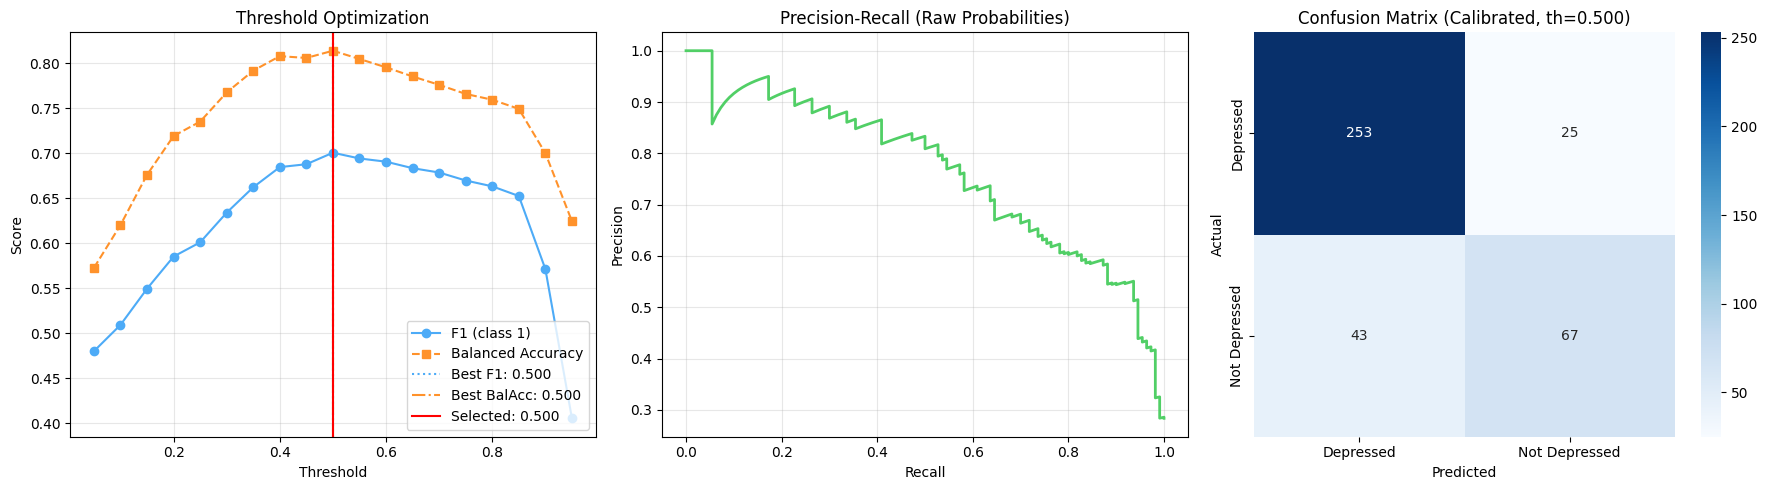

In [10]:
# testing and evaluating the model
from sklearn.metrics import precision_recall_curve, f1_score, balanced_accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
import numpy as np
import os

# make sure we have a model to test
if 'model' not in globals() or 'history' not in globals():
    if os.path.exists('best_mobilenet_depression_model.h5'):
        try:
            model = load_model('best_mobilenet_depression_model.h5')
            print("Loaded saved model")
        except Exception as e:
            print(f"Could not load model: {e}")
    else:
        print("No saved model found, need to train first")

# check if we have everything we need
missing = [name for name in ['model','val_generator','train_generator'] if name not in globals()]
if missing:
    print(f"Missing: {missing}. Please run previous cells first.")
else:
    val_generator.reset()
    y_pred_proba = model.predict(val_generator, verbose=0).ravel()  # probability of class 1 (Not_Depressed)
    y_true = val_generator.classes                                 # 0 = Depressed, 1 = Not_Depressed

    # Store raw predictions globally for later reuse
    val_y_true = y_true
    val_y_pred_proba_raw = y_pred_proba

    # Compute precision-recall curve (for class 1)
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_pred_proba)

    # Candidate thresholds to scan
    scan_thresholds = np.linspace(0.05, 0.95, 19)
    metrics_summary = []
    best_f1 = -1
    best_bal_acc = -1
    optimal_threshold_f1 = 0.5
    optimal_threshold_balanced = 0.5

    for th in scan_thresholds:
        y_pred = (y_pred_proba >= th).astype(int)
        f1 = f1_score(y_true, y_pred, average='binary')  # binary f1 for class 1
        bal_acc = balanced_accuracy_score(y_true, y_pred)
        metrics_summary.append((th, f1, bal_acc))
        if f1 > best_f1:
            best_f1 = f1
            optimal_threshold_f1 = th
        if bal_acc > best_bal_acc:
            best_bal_acc = bal_acc
            optimal_threshold_balanced = th

    # Choose primary threshold: prioritize balanced accuracy to avoid biased predictions
    optimal_threshold = optimal_threshold_balanced

    # Calibration (temperature-like logistic scaling)
    # Use logits transformation and logistic regression for probability calibration
    eps = 1e-6
    logits = np.log(np.clip(y_pred_proba, eps, 1-eps) / np.clip(1 - y_pred_proba, eps, 1-eps))
    X_logit = logits.reshape(-1, 1)
    calibrator = LogisticRegression(solver='lbfgs')
    calibrator.fit(X_logit, y_true)

    def calibrate_proba(p_array):
        p_array = np.clip(p_array, eps, 1-eps)
        lg = np.log(p_array / (1 - p_array)).reshape(-1,1)
        return calibrator.predict_proba(lg)[:,1]

    y_pred_proba_calibrated = calibrate_proba(y_pred_proba)

    # Re-evaluate with calibrated probabilities using selected threshold
    y_pred_calibrated = (y_pred_proba_calibrated >= optimal_threshold).astype(int)
    cm_optimal = confusion_matrix(y_true, y_pred_calibrated)
    report_optimal = classification_report(y_true, y_pred_calibrated, target_names=['Depressed','Not Depressed'])

    # Compute AUC for insight
    try:
        auc_score = roc_auc_score(y_true, y_pred_proba_calibrated)
    except Exception:
        auc_score = None

    # Persist globally
    optimal_threshold_balanced = optimal_threshold_balanced
    optimal_threshold_f1 = optimal_threshold_f1
    optimal_threshold = optimal_threshold  # alias used elsewhere
    best_f1_calibrated = f1_score(y_true, y_pred_calibrated, average='binary')
    calibration_available = True
    calibrated_val_probs = y_pred_proba_calibrated

    # ---- Plotting / Visualization ----
    plt.figure(figsize=(18,5))

    # Threshold vs F1 & Balanced Accuracy
    plt.subplot(1,3,1)
    ths = [m[0] for m in metrics_summary]
    f1s = [m[1] for m in metrics_summary]
    bals = [m[2] for m in metrics_summary]
    plt.plot(ths, f1s, 'o-', label='F1 (class 1)', color='#4dabf7')
    plt.plot(ths, bals, 's--', label='Balanced Accuracy', color='#ff922b')
    plt.axvline(optimal_threshold_f1, color='#4dabf7', linestyle=':', label=f'Best F1: {optimal_threshold_f1:.3f}')
    plt.axvline(optimal_threshold_balanced, color='#ff922b', linestyle='-.', label=f'Best BalAcc: {optimal_threshold_balanced:.3f}')
    plt.axvline(optimal_threshold, color='red', linestyle='-', label=f'Selected: {optimal_threshold:.3f}')
    plt.xlabel('Threshold'); plt.ylabel('Score'); plt.title('Threshold Optimization'); plt.legend(); plt.grid(alpha=0.3)

    # Precision-Recall curve (raw)
    plt.subplot(1,3,2)
    plt.plot(recall, precision, color='#51cf66', linewidth=2)
    plt.title('Precision-Recall (Raw Probabilities)')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.grid(alpha=0.3)

    # Confusion matrix (calibrated + selected threshold)
    plt.subplot(1,3,3)
    sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Depressed','Not Depressed'], yticklabels=['Depressed','Not Depressed'])
    plt.title(f'Confusion Matrix (Calibrated, th={optimal_threshold:.3f})')
    plt.xlabel('Predicted'); plt.ylabel('Actual')

    plt.tight_layout()
    plt.show()


    # Store decision logic preferences
    decision_strategy = 'argmax'  # alternative: 'threshold'
    uncertainty_margin = 0.15     # below this margin we flag as uncertain

    # Expose globals for prediction function
    globals().update({
        'decision_strategy': decision_strategy,
        'uncertainty_margin': uncertainty_margin,
        'calibrator': calibrator,
        'use_calibration': True,
        'optimal_threshold': optimal_threshold,
        'optimal_threshold_f1': optimal_threshold_f1,
        'optimal_threshold_balanced': optimal_threshold_balanced
    })

In [11]:
# function to predict depression from an image

def predict_depression_mobilenetv2(image_path, model=None, strategy=None, threshold=None, display_image=True):
    """
    takes an image and tells if person is depressed or not
    """
    try:
        if model is None:
            if 'model' in globals():
                model = globals()['model']
            else:
                raise ValueError("No model available. Train or load the model first.")

        # get the settings we saved earlier
        if strategy is None:
            strategy = globals().get('decision_strategy','argmax')
        if threshold is None:
            threshold = globals().get('optimal_threshold',0.5)
        use_calibration = globals().get('use_calibration', False)
        uncertainty_margin = globals().get('uncertainty_margin', 0.15)

        # load and prepare the image
        img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE), color_mode='rgb')
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        raw_proba = model.predict(img_array, verbose=0)[0][0]  # get prediction probability

        # adjust the probability if calibration is available
        if use_calibration and 'calibrator' in globals():
            eps = 1e-6
            p = np.clip(raw_proba, eps, 1-eps)
            logit = np.log(p/(1-p)).reshape(-1,1)
            calibrated_proba = calibrator.predict_proba(logit)[:,1][0]
        else:
            calibrated_proba = raw_proba

        prob_not_depressed = float(calibrated_proba)
        prob_depressed = float(1 - calibrated_proba)

        # decide which class it belongs to
        if strategy == 'threshold':
            predicted_class_idx = 1 if prob_not_depressed >= threshold else 0
            decision_basis = f"threshold >= {threshold:.3f}"
            confidence = abs(prob_not_depressed - threshold) + 0.5  # how confident we are
        else:  # using argmax method
            predicted_class_idx = 1 if prob_not_depressed >= 0.5 else 0
            decision_basis = 'argmax 0.5'
            confidence = max(prob_not_depressed, prob_depressed)

        predicted_label = 'Not Depressed' if predicted_class_idx == 1 else 'Depressed'

        # check if the model is unsure about the prediction - UnCertainity Detection.
        margin = abs(prob_not_depressed - 0.5)
        uncertain = margin < uncertainty_margin

        # show the results in graphs
        if display_image:
            plt.figure(figsize=(15,4))

            # show the input image
            plt.subplot(1,4,1)
            plt.imshow(img)
            plt.title(f'Input\n{os.path.basename(image_path)}')
            plt.axis('off')

            # show probability bars
            plt.subplot(1,4,2)
            labels = ['Depressed','Not Depressed']
            probs = [prob_depressed, prob_not_depressed]
            colors = ['#ff6b6b','#51cf66']
            bars = plt.bar(labels, probs, color=colors, alpha=0.85)
            plt.ylim(0,1)
            plt.title('Calibrated Probabilities')
            for b,pv in zip(bars, probs):
                plt.text(b.get_x()+b.get_width()/2., pv+0.02, f'{pv:.3f}', ha='center', va='bottom', fontweight='bold')
            if strategy=='threshold':
                plt.axhline(threshold, color='red', linestyle='--', label=f'Th={threshold:.3f}')
                plt.legend()

            # show final prediction
            plt.subplot(1,4,3)
            bar_color = '#51cf66' if predicted_class_idx==1 else '#ff6b6b'
            plt.bar(['Prediction'], [confidence], color=bar_color, alpha=0.85)
            plt.ylim(0,1)
            pred_title = predicted_label + (' (?)' if uncertain else '')
            plt.title(pred_title)
            plt.text(0, confidence+0.02, f'{confidence:.3f}', ha='center', va='bottom', fontweight='bold')

            # Uncertainty checking
            plt.subplot(1,4,4)
            levels = ['Certain','Borderline']
            meter_vals = [1 - margin/0.5, margin/0.5]
            meter_vals = [min(max(v,0),1) for v in meter_vals]
            plt.bar(levels, meter_vals, color=['#4dabf7','#ffa94d'], alpha=0.6)
            plt.ylim(0,1)
            plt.title(f'Margin {margin:.3f}')
            if uncertain:
                plt.text(1, meter_vals[1]+0.02, 'Uncertain', ha='center', fontweight='bold', color='#d9480f')
            plt.tight_layout()
            plt.show()

        result = {
            'prediction': predicted_label,
            'confidence': float(confidence),
            'probability_depressed': prob_depressed,
            'probability_not_depressed': prob_not_depressed,
            'strategy': strategy,
            'threshold_used': float(threshold if strategy=='threshold' else 0.5),
            'decision_basis': decision_basis,
            'uncertain': bool(uncertain),
            'uncertainty_margin': float(uncertainty_margin),
            'calibrated': bool(use_calibration)
        }
        return result

    except Exception as e:
        print(f"Error processing image: {e}")
        return None



Testing on Depressed sample: Disgust_26325.png


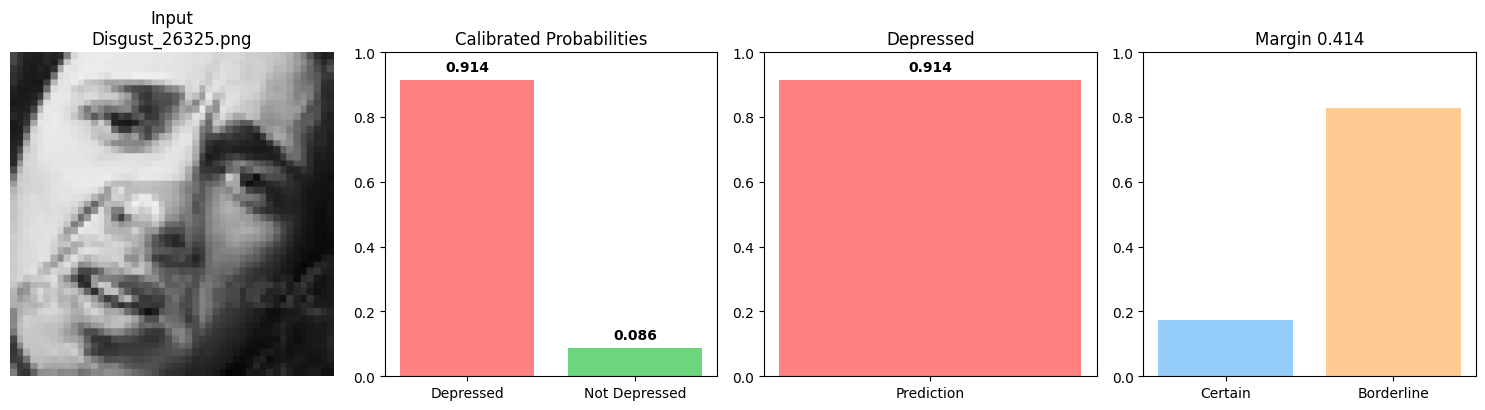

Prediction: {'prediction': 'Depressed', 'confidence': 0.9138788885430877, 'probability_depressed': 0.9138788885430877, 'probability_not_depressed': 0.08612111145691229, 'strategy': 'argmax', 'threshold_used': 0.5, 'decision_basis': 'argmax 0.5', 'uncertain': False, 'uncertainty_margin': 0.15, 'calibrated': True}

Testing on Not_Depressed sample: Happy_80.png


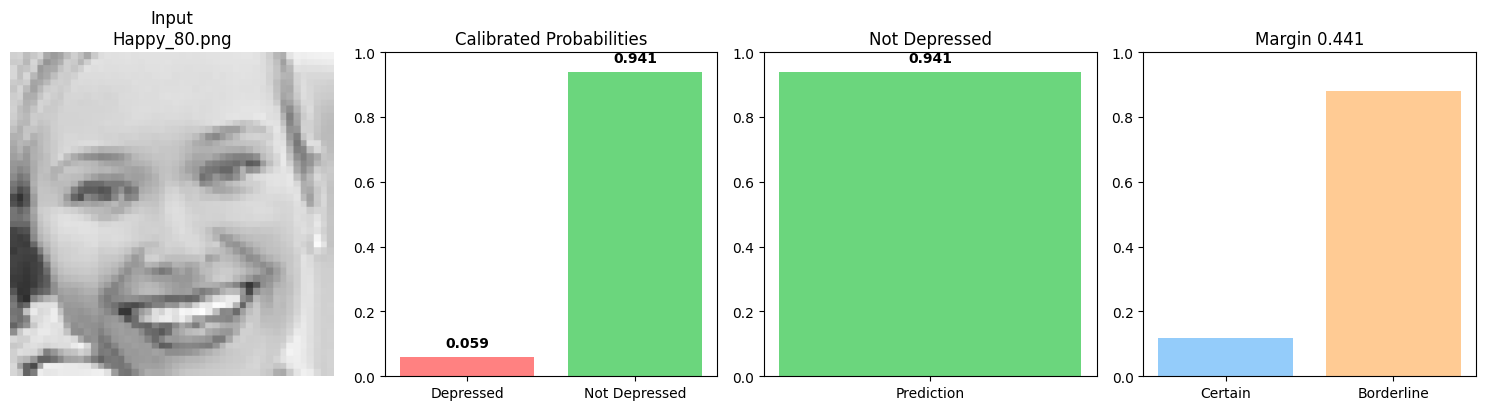

Prediction: {'prediction': 'Not Depressed', 'confidence': 0.9408310456974275, 'probability_depressed': 0.05916895430257252, 'probability_not_depressed': 0.9408310456974275, 'strategy': 'argmax', 'threshold_used': 0.5, 'decision_basis': 'argmax 0.5', 'uncertain': False, 'uncertainty_margin': 0.15, 'calibrated': True}


In [13]:
# testing the model on some random images and showing results using the graphs and showing prediction and then also showing the Margin of Certaininty and Borderline cases
import random
import glob

for cls in ['Depressed', 'Not_Depressed']:
    test_images = glob.glob(f'depression_data/test/{cls}/*.png')
    if test_images:
        sample = random.choice(test_images)
        print(f"\nTesting on {cls} sample: {os.path.basename(sample)}")
        result = predict_depression_mobilenetv2(sample, display_image=True)
        print("Prediction:", result)
    else:
        print(f"No {cls} test images found.")